In [1]:
import os

import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from Utils import *

In [2]:
#Variable Definition
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

In [3]:
#importing data the .npy files which are nothing but numpy arrays created with the help 
# of the preprocess.py
X = np.load('Data/X.npy')
Y = np.load('Data/Y.npy')

In [4]:
print(X.shape , Y.shape)

(480, 512, 512, 3) (480, 16, 16, 1, 5)


In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,train_size = 0.75 , shuffle = True)
X = []
Y = []

In [6]:
print(X_val.shape, Y_val.shape)
print("**************************")
print(X_val.shape[0])

(120, 512, 512, 3) (120, 16, 16, 1, 5)
**************************
120


In [20]:
#define model
# input : 512,512,3
# output : 16,16,1,5

#This function is used to store the model so that we don't have to train the model
#each and every time we run the applications
def save_model(model):
    model_json = model.to_json()
    with open("model/text_detect_model.json", "w") as json_file:
        json_file.write(model_json)

#This function is used to load the model already available in the disk.
def load_model(strr):        
    with open(strr, 'r') as json_file:
        loaded_model_json = json_file.read()
    #below is the loaded_model
    return model_from_json(loaded_model_json)


#After loading the model you can use this use the model in this manner
# loaded_model.load_weights("model.h5")

# # evaluate loaded model on test data
# loaded_model.compile(loss='loss-function', optimizer='', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
       

#SO this is a case of transform learning where the mobilenet_v2 model which is trained 
# on the imagenet dataset for image classification is then further trained to create a new model
# for our use case.

#Input: is used to instantiate a Keras tensor which allows us to create a keras model with 
# just by knowing the input and output. Basically allows us to create the first input layer in an 
# Convolutional Neural Network.
    

#Dropout: So dropout is nothing but neurons being dropped out of the model while training randomly
#This means that their contribution to the activation of downstream neurons is temporally removed
#  on the forward pass, and any weight updates are not applied to the neuron on the backward pass
#This is done in order to avoid overfitting the model.

#BatchNormalization: is used to normalized the inputs and it keeps the mean closer to zero 
# and the standard deviation closer to one.

#LeakyReLU layer: is basically a RElu layer with better flexibility i.e LeakyReLU has the ability to retain some degree
#  of the negative values that flow into it, 
# whilst the relu activation layer simply sets all values less than 0 to be 0. 

def yolo_model(input_shape):
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    #@ activation='relu' (Rectified Lienar Unit) basically outputs everything positive
    # that is it doesn't allow output of layer to return negative values

    #First Covolutional layer
    conv = Conv2D(512, (3,3), activation='relu' , padding='same')(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
 
    #Second Covolutional layer
    conv = Conv2D(128, (3,3), activation='relu', padding='same')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    #Third Covolutional layer
    conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
    
    final = Reshape((grid_h,grid_w,classes,info))(conv)
    
    #Creating the final model with input and output
    model = Model(inp, final)
    
    return model


In [8]:
#define utils

#optimizer
#Adam optimizer basically adjusts the weights to minimize the error rate and produce accurate results.
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

#checkpoint
checkpoint = ModelCheckpoint('model/text_detect.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)


d:\Projects\BE Project\BE_TIFR_PROJECT\YOLO\yolo algo\text-detection\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
#define loss function
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]

    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss

    #Calculating the loss
    return p_loss_absent + p_loss_present + xy_loss + wh_loss

In [27]:
#load and save model
input_size = (img_h,img_w,channels)

model = yolo_model(input_size)

print(model.summary())

save_model(model)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [28]:
model.load_weights('model/text_detect.h5')

In [29]:
model.compile(loss=yolo_loss_func , optimizer=opt , metrics = ['accuracy'])

In [13]:
hist = model.fit(X_train ,Y_train ,epochs= 30 ,batch_size = 4 , callbacks=[checkpoint] , validation_data=(X_val,Y_val))

Epoch 1/30
90/90 [==============================] - ETA: 0s - loss: nan - accuracy: 0.9047
Epoch 1: val_loss did not improve from inf
90/90 [==============================] - 372s 4s/step - loss: nan - accuracy: 0.9047 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/30
90/90 [==============================] - ETA: 0s - loss: nan - accuracy: 1.0000
Epoch 2: val_loss did not improve from inf
90/90 [==============================] - 367s 4s/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/30
90/90 [==============================] - ETA: 0s - loss: nan - accuracy: 1.0000
Epoch 3: val_loss did not improve from inf
90/90 [==============================] - 359s 4s/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/30
90/90 [==============================] - ETA: 0s - loss: nan - accuracy: 1.0000
Epoch 4: val_loss did not improve from inf
90/90 [==============================] - 348s 4s/step - loss: nan - accuracy: 1.0000 - val_l

In [30]:
model.save_weights('model/text_detect.h5')

In [17]:
save_model(model)

In [39]:
model = load_model('model/text_detect_model.json')
model.load_weights('model/text_detect.h5')

In [40]:
def predict_func(model , inp , iou , name):

    ans = model.predict(inp)
    
    #np.save('Results/ans.npy',ans)
    boxes = decode(ans[0] , img_w , img_h , iou)
    
    img = ((inp + 1)/2)
    img = img[0]
    #plt.imshow(img)
    #plt.show()

    for i in boxes:
        i = [int(x) for x in i]
        img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (0,255,0) , thickness = 2)

    plt.imshow(img)
    plt.show()

    cv2.imwrite(os.path.join('Results' , str(name) + '.jpg') , img*255.0)
    

In [41]:
from keras.applications.mobilenet_v2 import preprocess_input

test_data = np.empty((3, 512, 512, 3))

test_data[0] = cv2.imread("./test-dataset/frame_0.jpg")
test_data[0] = preprocess_input(test_data[0])
test_data[0] = cv2.resize(test_data[0], (512, 512))



1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


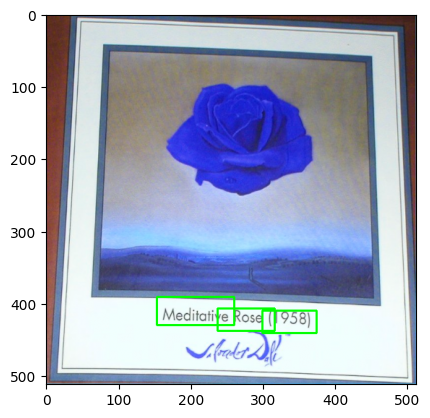

1/1 [==============================] - 0s 217ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


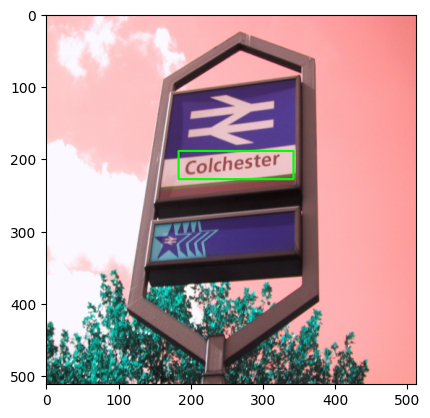

1/1 [==============================] - 0s 199ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


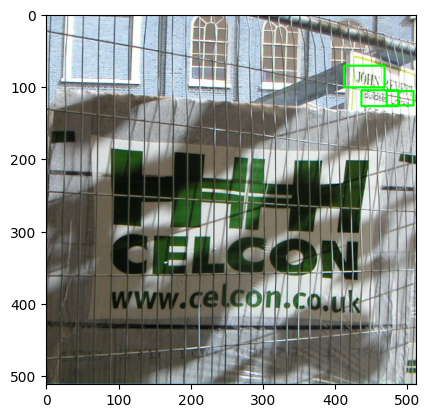

1/1 [==============================] - 0s 189ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


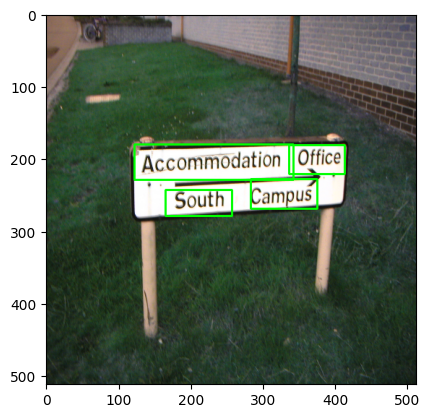

1/1 [==============================] - 0s 191ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


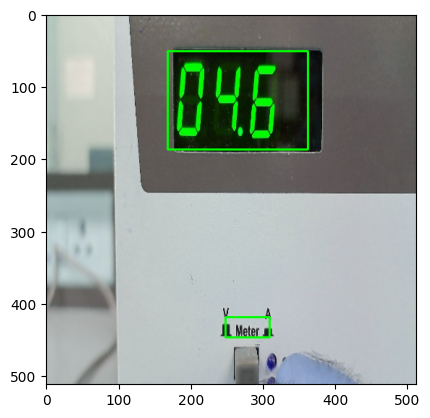

In [42]:
rand = np.random.randint(0,X_val.shape[0], size = 5)

for i in rand:
    predict_func(model , X_val[i:i+1] , 0.5, i)
    

1/1 [==============================] - 0s 181ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


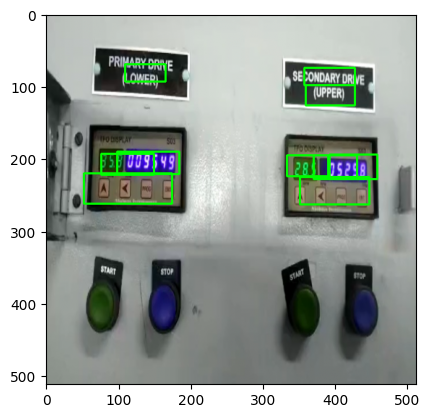

1/1 [==============================] - 0s 171ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


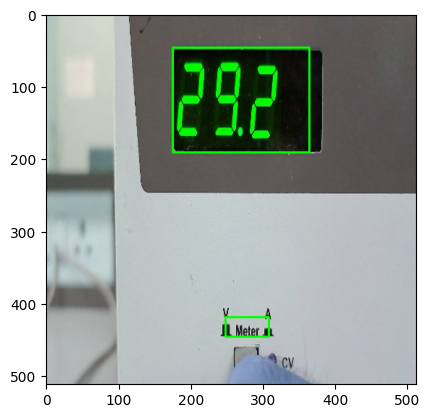

1/1 [==============================] - 0s 203ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


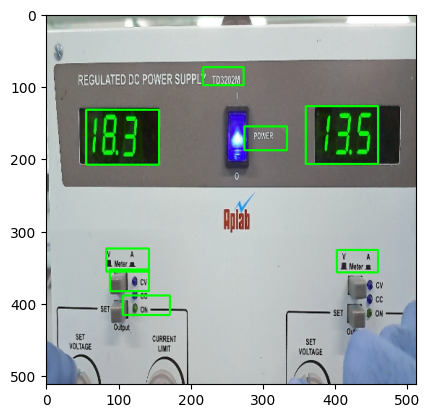

1/1 [==============================] - 0s 184ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


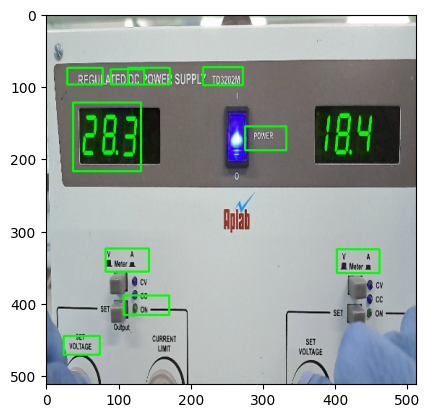

1/1 [==============================] - 0s 201ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


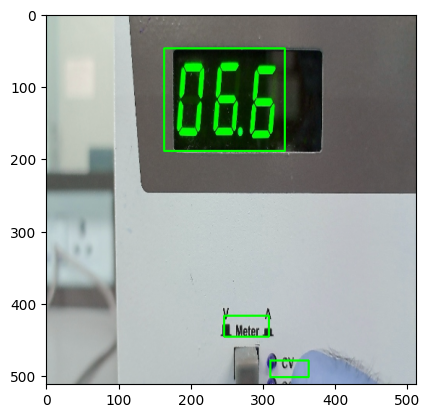

1/1 [==============================] - 0s 176ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


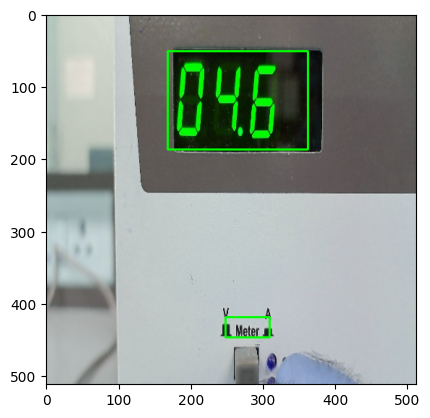

In [43]:
for i in os.listdir('Test'):
    img = cv2.imread(os.path.join('Test',i))
    img = cv2.resize(img,(512,512))
    img = (img - 127.5)/127.5
    predict_func(model , np.expand_dims(img,axis= 0) , 0.5 , 'sample')

### THE END